# Imports 

In [1]:
from aptos_sdk.account import Account
from aptos_sdk.bcs import Serializer
from aptos_sdk.client import RestClient, FaucetClient
from aptos_sdk.transactions import (
    EntryFunction,
    ModuleId,
    TransactionArgument as TxArg,
    TransactionPayload as TxPayload)
from aptos_sdk.type_tag import StructTag
from IPython.display import clear_output
from typing import Any, Dict

import pandas as pd

# Account via keyfile

In [2]:
# Relative path to hot keyfile for testing only.
# File should contain hex key only.
key_file = '../../.secrets/2f4418ed678986669b22\
ca40c664aa04707cacc5a326b47f0b4d540dff05e4c1.key'
with open(key_file) as f: # Open file.
    key = f.readline().rstrip() # Get key.
# Get account from key.
account = Account.load_key(key)
# Print account address in hex.
account.address().hex()

'0x2f4418ed678986669b22ca40c664aa04707cacc5a326b47f0b4d540dff05e4c1'

# REST Client 

In [3]:
# Declare base URL for testnet REST API.
client_url = 'https://fullnode.testnet.aptoslabs.com/v1'
# Declare base URL for faucet.
faucet_url = 'https://faucet.testnet.aptoslabs.com'
# Initialize client.
client = RestClient(client_url)
# Initialize faucet.
faucet = FaucetClient(faucet_url, client)
# Get account balance
client.account_balance(account.address())

'120907500'

In [4]:
# Fund from the faucet
faucet.fund_account(account.address().hex(), 1000000000)

In [5]:
# Get account balance
client.account_balance(account.address())

'220907500'

In [6]:
def execute(function: str, args: list) -> str:
    """Call entry function with args, returning tx hash
    
    args should be of format
    [[4, Serializer.u64], [2, Serializer.u128]]
    """
    # Construct entry function payload.
    payload = EntryFunction.natural(
        str(module_id),
        function,
        [],
        [TxArg(a[0], a[1]) for a in args])
    # Generate a signed transaction from the payload.
    signed_tx = client.create_single_signer_bcs_transaction(
        account, TxPayload(payload))
    # Submit signed transaction, returning transaction ID.
    return client.submit_bcs_transaction(signed_tx)

In [7]:
def get_tx_json(hash: str) -> Dict[str, Any]:
    """Query a transaction by hash, returning JSON data"""
    while(True):
        response = client.client.get(
            f'{client.base_url}/transactions/by_hash/{hash}')
        # Assert successful response.
        assert response.status_code == 200, hash
        # If transaction has cleared as user tx:
        if response.json()['type'] == 'user_transaction':
            # Return its JSON data
            return response.json()
        # Otherwise try again

In [8]:
def print_tx_url(version: str):
    """Print URL to transaction view on explorer"""
    explorer = 'https://aptos-explorer.netlify.app'
    print(f'{explorer}/txn/{version}')

In [9]:
def tx_diagnostics(tx_json: Dict[str, Any]):
    """Print gas used or link to failed tx"""
    if tx_json['success'] == True:
        print(f'Gas used: {tx_json["gas_used"]}')
    else:
        print_tx_url(tx_json['version'])

# Crit-queue interface

In [10]:
def get_access_key(insertion_key: int,
                   insertion_count: int) -> int:
    """Return access key for insertion key/count"""
    return insertion_key << 64 | insertion_count

In [11]:
# Declare module name.
module = 'critqueue_benchmark'
# Get module ID.
module_id = ModuleId(account.address(), module)
# Get CritQueueStore struct tag.
struct_tag = StructTag(account.address(),
                       module,
                      'CritQueueStore',
                       [])
# Check that account has one.
client.account_resource(account.address(),
                        struct_tag.__str__())

{'type': '0x2f4418ed678986669b22ca40c664aa04707cacc5a326b47f0b4d540dff05e4c1::critqueue_benchmark::CritQueueStore',
 'data': {'map': {'inner': {'handle': '0xa157b831945a15c1eff5bb55df13f269ace1d40c7221ad6b3c9fcf679ba48762'},
   'length': '53'}}}

In [12]:
def insert(insertion_key: int,
           insertion_value: int) -> str:
    """Insert given key-value insertion pair,
    returning tx ID"""
    return execute('insert', [
        [insertion_key, Serializer.u64],
        [insertion_value, Serializer.u64]
    ])

In [13]:
def remove(insertion_key: int,
           insertion_count: int,
           insertion_value_expected: int) -> str:
    """Remove corresponding key-value insertion pair,
    returning tx ID"""
    access_key = get_access_key(
        insertion_key, insertion_count)
    return execute('remove', [
        [access_key, Serializer.u128],
        [insertion_value_expected, Serializer.u64]
    ])

In [14]:
def dequeue(insertion_value_expected: int) -> str:
    """Dequeue, checking insertion value and
    returning tx ID"""
    return execute('dequeue', [
        [insertion_value_expected, Serializer.u64]
    ])

In [15]:
def dequeue_all() -> str:
    """Dequeue all, returning tx ID"""
    return execute('dequeue_all', [])

In [16]:
def reset() -> str:
    """Reset crit-queue, returning tx ID"""
    return execute('reset', [])

In [17]:
# Reset.
tx_diagnostics(get_tx_json(reset()))

Gas used: 428


In [18]:
# Insert key-value pair.
tx_diagnostics(get_tx_json(insert(10, 1)))

Gas used: 659


In [19]:
# Try removing key-value pair.
tx_diagnostics(get_tx_json(remove(10, 0, 1)))

Gas used: 288


In [20]:
# Insert several key-value pairs.
for i in range(4):
    # Wait until successful.
    tx_diagnostics(get_tx_json(insert(10, 1)))
# Dequeue.
tx_diagnostics(get_tx_json(dequeue(1)))

Gas used: 493
Gas used: 501
Gas used: 502
Gas used: 502
Gas used: 329


In [21]:
# Dequeue all.
tx_diagnostics(get_tx_json(dequeue_all()))

Gas used: 358


In [22]:
# Reset.
tx_diagnostics(get_tx_json(reset()))

Gas used: 428


# Simple scenarios

Inserting at the root allocates a leaf and a sub-queue node:

In [23]:
tx_diagnostics(get_tx_json(insert(
    insertion_key=0,
    insertion_value=1)))

Gas used: 659


Inserting behind in the same leaf only has to allocate a sub-queue node:

In [24]:
tx_diagnostics(get_tx_json(insert(
    insertion_key=0,
    insertion_value=1)))

Gas used: 501


Inserting a new leaf now has to allocate a leaf, inner node, and sub-queue node:

In [25]:
tx_diagnostics(get_tx_json(insert(
    insertion_key=1,
    insertion_value=1)))

Gas used: 947


Removing the value deallocates the sub-queue node, frees the leaf, and deallocates an inner node:

In [26]:
tx_diagnostics(get_tx_json(remove(
    insertion_key=1,
    insertion_count=0,
    insertion_value_expected=1)))

Gas used: 358


Inserting again has to re-insert the free leaf to the tree (but not reallocate it), allocate a new inner node, and allocate a new sub-queue node:

In [27]:
tx_diagnostics(get_tx_json(insert(
    insertion_key=1,
    insertion_value=1)))

Gas used: 779


# Unbalanced insertion, removal

In [28]:
# Reset.
tx_diagnostics(get_tx_json(reset()))

Gas used: 428


Insert keys in the following prder, creating an unbalanced tree of maximum height:
1. `0b0`
2. `0b10`
3. `0b100`

...

64. `0b10000.`

Here, each successive insertion has to walk more nodes during a search, producing the following tree:

>                   63rd
>                  /    \
>               62nd    100000000000000.....
>             ...
>            2nd
>           /   \
>         1st   100 
>        /   \
>      0th   10
>     /   \
>     0   1

For ease of illustration, inner keys are depicted relative to bit 64.

In [29]:
# Reset crit-queue store, waiting until tx clears.
tx_diagnostics(get_tx_json(reset()))
gas = {} # Init map from shift to gas used.
for bit in range(64): # Loop over all bits
    shifted = 0 # Assume no bitshift.
    if bit != 0: # If should shift.
        shifted = 1 << bit # Shift amount.
    # Store JSON for key-value insertion pair tx.
    tx_json = get_tx_json(insert(
        insertion_key=shifted,
        insertion_value=shifted))
    # Assert successful transaction.
    assert tx_json['success'] == True
    # Log gas used for given shift.
    gas[bit] = int(tx_json['gas_used'])
    clear_output(wait=True) # Clear terminal output.
    # Print gas used.
    print(f'Post-insertion height: {bit}, gas: {gas[bit]}')
clear_output() # Clear terminal output.

In [30]:
# Get gas DataFrame.
gas_df = pd.DataFrame.from_dict(gas.items()).rename(
    columns={
        0: 'Post-insertion height',
        1: 'Gas used'})

Here, gas costs scale linearly with post-insertion height, where for each insertion:
1. A new inner node must be allocated,
2. A new leaf must be allocated, and
3. A new sub-queue node must be allocated, after
4. Searching every node along the height of the tree, then traversing back up,

except in the case of the first insertion at the root, where a new inner node does not have to be allocated and there is no height to search:

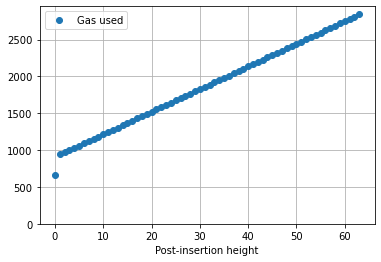

In [31]:
ax = gas_df.plot(x='Post-insertion height',
                 y='Gas used',
                 grid=True,
                 style='o');
ax.set_ylim(ymin=0);

Removals are `O(1)`, and thus unaffected by height, but may vary with changes to the root or the head:

In [32]:
print('Changes root:')
tx_diagnostics(get_tx_json(remove(1 << 63, 0, 1 << 63)))
print('Changes head:')
tx_diagnostics(get_tx_json(remove(0, 0, 0)))
print('Changes neither:')
tx_diagnostics(get_tx_json(remove(1 << 31, 0, 1 << 31)))
tx_diagnostics(get_tx_json(remove(1 << 15, 0, 1 << 15)))
tx_diagnostics(get_tx_json(remove(1 << 47, 0, 1 << 47)))

Changes root:
Gas used: 358
Changes head:
Gas used: 441
Changes neither:
Gas used: 367
Gas used: 367
Gas used: 367


Dequeuing all nodes is costly:

In [33]:
tx_diagnostics(get_tx_json(dequeue_all()))

Gas used: 8681


# Balanced insertion

For a balanced tree, instead insert the values:
* `0b0000000`
* `0b0000001`
* `0b0000010`
* `0b0000011`

...

* `0b1111111`

In [37]:
# Reset crit-queue store, waiting until tx clears.
tx_diagnostics(get_tx_json(reset()))
gas = {} # Init map from shift to gas used.
for i in range(2 ** 7): # Loop over all 7-bit integers.
    # Store JSON for key-value insertion pair tx.
    tx_json = get_tx_json(insert(
        insertion_key=i,
        insertion_value=i))
    # Assert successful transaction.
    assert tx_json['success'] == True
    # Log gas used for given insertion.
    gas[i] = int(tx_json['gas_used'])
    clear_output(wait=True) # Clear terminal output.
    # Print gas used.
    print(f'Pre-insertion leaf count: {i}, gas: {gas[i]}')
clear_output() # Clear terminal output.

In [38]:
# Get gas DataFrame.
gas_df = pd.DataFrame.from_dict(gas.items()).rename(
    columns={
        0: 'Pre-insertion leaf count',
        1: 'Gas used'})

Here, after the first insertion at the root, gas costs (theoretically) scale logarithmically with the number of leaves in the tree, but are nearly constant in practice:

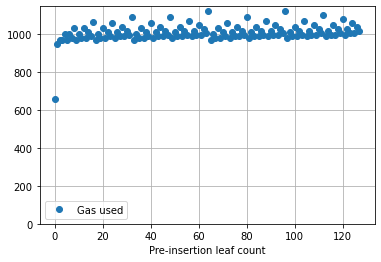

In [39]:
ax = gas_df.plot(x='Pre-insertion leaf count',
                 y='Gas used',
                 grid=True,
                 style='o');
ax.set_ylim(ymin=0);